  0%|                                                  | 0/365 [00:00<?, ?it/s]

(375, 450)
(375, 450)


100%|████████████████████████████████████████| 365/365 [03:48<00:00,  1.60it/s]


generating 3d point cloud...
PointsCloud_T.ply saved


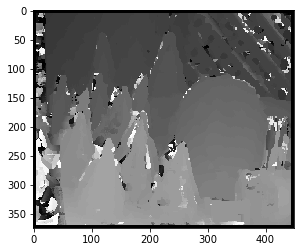

In [1]:
import cv2 as cv
import numpy as np
from tqdm import *
import matplotlib.pyplot as plt

BLOCK_SIZE = 10
SEARCH_BLOCK_SIZE = 80
left_image_path="im2.png"
right_image_path="im6.png"

#Can by opened by Meshlab
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

def _read_left_right_image_pair(left_image_path=left_image_path,
                                right_image_path=right_image_path):
    # Load an color image in grayscale
    left_im = cv.imread(left_image_path, 0)
    right_im = cv.imread(right_image_path, 0)
    # Convert image to array
    left_im_array = np.asarray(left_im)
    right_im_array = np.asarray(right_im)
    print(left_im_array.shape)
    print(right_im_array.shape)

    return left_im_array, right_im_array


def compare_blocks(y, x, block_left, right_array, block_size=BLOCK_SIZE):
    """
    Compare left block of pixels with multiple blocks from the right
    image using SEARCH_BLOCK_SIZE to constrain the search in the right
    image.
    Args:
        y (int): row index of the left block
        x (int): column index of the left block
        block_left (numpy.ndarray): containing pixel values within the 
                    block selected from the left image
        right_array (numpy.ndarray]): containing pixel values for the 
                     entrire right image
        block_size (int, optional): Block of pixels width and height. 
                                   #Can be smaller/BLOCK_SIZE
    Returns:
        tuple: (y, x) row and column index of the best matching block 
                in the right image
    """
    # Get search range for the right image
    x_min = max(int(block_size/2), x - SEARCH_BLOCK_SIZE)
    x_max = min(right_array.shape[1]-int(block_size/2), x + SEARCH_BLOCK_SIZE)
    first = True
    min_sad = None
    min_index = None
    for x in range(x_min, x_max):
        block_right = right_array[y-int(block_size/2): y+int(block_size/2),
                                  x-int(block_size/2): x+int(block_size/2)]
        
        if block_left.shape != block_right.shape:
            return -1
        else:
            sad = np.sum(abs(block_left - block_right))
        
        if first:
            min_sad = sad
            min_index = (y, x)
            first = False
        else:
            if sad < min_sad:
                min_sad = sad
                min_index = (y, x)

    return min_index

#get_disparity_map
left_array, right_array = _read_left_right_image_pair()
left_array = left_array.astype(int)
right_array = right_array.astype(int)
if left_array.shape != right_array.shape:
    raise "Left-Right image shape mismatch!"
h, w = left_array.shape
disparity_map = np.zeros((h, w)).astype(np.float32)
# Go over each pixel position
for y in tqdm(range(int(BLOCK_SIZE/2), h-int(BLOCK_SIZE/2))):
    for x in range(int(BLOCK_SIZE/2), w-int(BLOCK_SIZE/2)):
        block_left = left_array[y-int(BLOCK_SIZE/2):y + int(BLOCK_SIZE/2),
                                x-int(BLOCK_SIZE/2):x + int(BLOCK_SIZE/2)]
        min_index = compare_blocks(y, x, block_left,
                                   right_array,
                                   block_size=BLOCK_SIZE)
        disparity_map[y, x] = (min_index[1] - x)

print('generating 3d point cloud...',)
h, w = left_array.shape[:2]
f = 0.8*w                          # guess for focal length
Q = np.float32([[1, 0, 0, -0.5*w],
                [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis, 
                [0, 0, 0,     -f], # so that y-axis looks up
                [0, 0, 1,      0]])
points = cv.reprojectImageTo3D(abs(disparity_map), Q)
colors = cv.cvtColor(cv.imread(left_image_path, cv.IMREAD_COLOR), cv.COLOR_BGR2RGB)

mask = abs(disparity_map) > 0 #< LIMIT #disparity_map.min()
out_points = points[mask.astype(np.bool)]
out_colors = colors[mask.astype(np.bool)]
out_fn = 'PointsCloud_T.ply'
write_ply(out_fn, out_points, out_colors)
print('%s saved' % out_fn)        
        
disparity_map = np.uint8(abs(disparity_map))      

plt.imshow(disparity_map, cmap='gray', interpolation='nearest')
plt.savefig('depth_image_T.png')
plt.show()

  0%|                                                  | 0/355 [00:00<?, ?it/s]

(375, 450)
(375, 450)


100%|████████████████████████████████████████| 355/355 [05:57<00:00,  1.01s/it]


generating 3d point cloud...
PointsCloud.ply saved


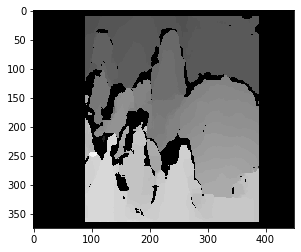

In [2]:
import cv2 as cv
import numpy as np
from tqdm import *
import matplotlib.pyplot as plt


BLOCK_SIZE = 20
SEARCH_ESTIMATION_INI = -30
LIMIT = 100
CRITERE = 0.3

left_image_path="im2.png"
right_image_path="im6.png"
left_im = cv.imread(left_image_path, 0)
right_im = cv.imread(right_image_path, 0)
# Convert image to array
left_im_array = np.asarray(left_im)
right_im_array = np.asarray(right_im)
print(left_im_array.shape)
print(right_im_array.shape)
left_array = left_im_array.astype(int)
right_array = right_im_array.astype(int)
if left_array.shape != right_array.shape:
    raise "Left-Right image shape mismatch!"
    
#get_disparity_map
h, w = left_array.shape
disparity_map = np.zeros((h, w)).astype(np.float32)

#Can by opened by Meshlab
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

def compare_blocks(y, x, block_left, right_array, block_size=BLOCK_SIZE):
    # Get search range for the right image
    x_min = max(int(block_size/2), int(x + (SEARCH_ESTIMATION-30)))
    x_max = min(right_array.shape[1]-int(block_size/2), int(x + (SEARCH_ESTIMATION+30)))
    min_index = (y, x)
    min_sad = CRITERE
    for xx in range(x_min, x_max):
        
        block_right = right_array[y-int(block_size/2): y+int(block_size/2),
                                  xx-int(block_size/2): xx+int(block_size/2)]
        
        if block_left.shape != block_right.shape:
            print('Shape of 2 blocks should be similar')
            return -1
        else:
            m_l = np.mean(block_left)
            m_r = np.mean(block_right)          
            # zero centred normalized cross-correlation coefficient
            sad = 1 - np.sum(np.multiply(block_left-m_l, block_right-m_r))/np.sqrt(np.sum(np.multiply(block_left-m_l,block_left-m_l))*np.sum(np.multiply(block_right-m_r,block_right-m_r)))
        
        if sad < min_sad:
            min_sad = sad
            min_index = (y, xx) 
            
    return min_index

###################""# Go over each pixel position
SEARCH_ESTIMATION = SEARCH_ESTIMATION_INI
for y in tqdm(range(int(BLOCK_SIZE/2), h-int(BLOCK_SIZE/2))):
    for x in range(max(int(BLOCK_SIZE/2+LIMIT/2),int(BLOCK_SIZE/2+LIMIT/2-SEARCH_ESTIMATION_INI)), min(int(w-LIMIT/2-BLOCK_SIZE/2),int(w-LIMIT/2-BLOCK_SIZE/2)-SEARCH_ESTIMATION_INI)):
        block_left = left_array[y-int(BLOCK_SIZE/2):y + int(BLOCK_SIZE/2),
                                x-int(BLOCK_SIZE/2):x + int(BLOCK_SIZE/2)]
        min_index = compare_blocks(y, x, block_left, right_array, block_size=BLOCK_SIZE)
        disparity_map[y, x] = (min_index[1] - x)

print('generating 3d point cloud...',)
h, w = left_array.shape[:2]
f = 0.8*w                          # guess for focal length
Q = np.float32([[1, 0, 0, -0.5*w],
                [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis, 
                [0, 0, 0,     -f], # so that y-axis looks up
                [0, 0, 1,      0]])
points = cv.reprojectImageTo3D(abs(disparity_map), Q)
colors = cv.cvtColor(cv.imread(left_image_path, cv.IMREAD_COLOR), cv.COLOR_BGR2RGB)

mask = abs(disparity_map) > 0 #< LIMIT #disparity_map.min()
out_points = points[mask.astype(np.bool)]
out_colors = colors[mask.astype(np.bool)]
out_fn = 'PointsCloud.ply'
write_ply(out_fn, out_points, out_colors)
print('%s saved' % out_fn)
        
# Normalize the values to a range from 0..255 for a grayscale image
Disparity = cv.normalize(abs(disparity_map), abs(disparity_map), alpha=255, beta=0, norm_type=cv.NORM_MINMAX)
Disparity = np.uint8(Disparity)

plt.imshow(Disparity, cmap='gray', interpolation='nearest')
plt.savefig('DepthMap.png')
plt.show()

  0%|                                                  | 0/355 [00:00<?, ?it/s]

(375, 450)
(375, 450)


100%|████████████████████████████████████████| 355/355 [02:42<00:00,  2.18it/s]


generating 3d point cloud...
PointsCloud_2.ply saved


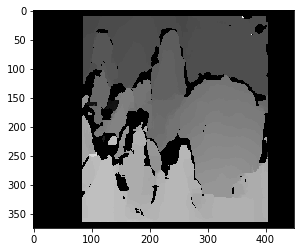

In [3]:
import cv2 as cv
import numpy as np
from tqdm import *
import matplotlib.pyplot as plt


BLOCK_SIZE = 20
SEARCH_ESTIMATION_INI = -40
n_max = 6 #+-50
LIMIT = 70
CRITERE = 0.3

left_image_path="im2.png"
right_image_path="im6.png"
left_im = cv.imread(left_image_path, 0)
left_im = cv.blur(left_im, (1, 1), cv.BORDER_CONSTANT)
right_im = cv.imread(right_image_path, 0)
right_im = cv.blur(right_im, (1, 1), cv.BORDER_CONSTANT)
# Convert image to array
left_im_array = np.asarray(left_im)
right_im_array = np.asarray(right_im)
print(left_im_array.shape)
print(right_im_array.shape)
left_array = left_im_array.astype(int)
right_array = right_im_array.astype(int)
if left_array.shape != right_array.shape:
    raise "Left-Right image shape mismatch!"
    
#get_disparity_map
h, w = left_array.shape
disparity_map = np.zeros((h, w)).astype(np.float32)

#Can by opened by Meshlab
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

def compare_blocks(y, x, block_left, right_array, search_estimation, block_size=BLOCK_SIZE):
    min_index = (y, x)
    min_sad = CRITERE
    n = 1
    while np.logical_and(n<n_max, min_sad == CRITERE):
        # Get search range for the right image
        x_min = max(int(block_size/2), int(x + (search_estimation-10*n)))
        x_max = min(right_array.shape[1]-int(block_size/2), int(x + (search_estimation+10*n)))
        if n==1:          
            for xx in range(x_min, x_max):
                block_right = right_array[y-int(block_size/2): y+int(block_size/2),
                                          xx-int(block_size/2): xx+int(block_size/2)]
                #if block_left.shape != block_right.shape:
                    #print('Shape of 2 blocks should be similar')
                    #return -1
                #else:
                m_l = np.mean(block_left)
                m_r = np.mean(block_right)
                # zero centred normalized cross-correlation coefficient
                sad = 1 - np.sum(np.multiply(block_left-m_l, block_right-m_r))/np.sqrt(np.sum(np.multiply(block_left-m_l,block_left-m_l))*np.sum(np.multiply(block_right-m_r,block_right-m_r)))
                if sad < min_sad:
                    min_sad = sad
                    min_index = (y, xx) 
        else:
            if min_sad == CRITERE:               
                for xx in range(x_min,X_min):
                    block_right = right_array[y-int(block_size/2): y+int(block_size/2),
                                              xx-int(block_size/2): xx+int(block_size/2)]
                    m_l = np.mean(block_left)
                    m_r = np.mean(block_right)
                    # zero centred normalized cross-correlation coefficient
                    sad = 1 - np.sum(np.multiply(block_left-m_l, block_right-m_r))/np.sqrt(np.sum(np.multiply(block_left-m_l,block_left-m_l))*np.sum(np.multiply(block_right-m_r,block_right-m_r)))
                    if sad < min_sad:
                        min_sad = sad
                        min_index = (y, xx) 
            else:              
                for xx in range(X_max,x_max):
                    block_right = right_array[y-int(block_size/2): y+int(block_size/2),
                                              xx-int(block_size/2): xx+int(block_size/2)]
                    m_l = np.mean(block_left)
                    m_r = np.mean(block_right)
                    # zero centred normalized cross-correlation coefficient
                    sad = 1 - np.sum(np.multiply(block_left-m_l, block_right-m_r))/np.sqrt(np.sum(np.multiply(block_left-m_l,block_left-m_l))*np.sum(np.multiply(block_right-m_r,block_right-m_r)))
                    if sad < min_sad:
                        min_sad = sad
                        min_index = (y, xx)                    
        X_min = x_min
        X_max = x_max
        n+=1
    #print(min_sad)
    return min_index

###################""# Go over each pixel position
SEARCH_ESTIMATION = SEARCH_ESTIMATION_INI
for y in tqdm(range(int(BLOCK_SIZE/2), h-int(BLOCK_SIZE/2))):
    for x in range(max(int(BLOCK_SIZE/2+LIMIT/2),int(BLOCK_SIZE/2+LIMIT/2-SEARCH_ESTIMATION_INI)), min(int(w-LIMIT/2-BLOCK_SIZE/2),int(w-LIMIT/2-BLOCK_SIZE/2)-SEARCH_ESTIMATION_INI)):
        block_left = left_array[y-int(BLOCK_SIZE/2):y + int(BLOCK_SIZE/2),
                                x-int(BLOCK_SIZE/2):x + int(BLOCK_SIZE/2)]
        min_index = compare_blocks(y, x, block_left, right_array, search_estimation=SEARCH_ESTIMATION, block_size=BLOCK_SIZE)
        if abs(min_index[1] - x) < LIMIT:
            disparity_map[y, x] = (min_index[1] - x)
            SEARCH_ESTIMATION = disparity_map[y, x]
        else :
            disparity_map[y, x] = 0
            SEARCH_ESTIMATION = SEARCH_ESTIMATION_INI
##################
    if abs(disparity_map[y, 0]) != 0:
        SEARCH_ESTIMATION = disparity_map[y, 0]
    else:
        SEARCH_ESTIMATION = SEARCH_ESTIMATION_INI
##################

print('generating 3d point cloud...',)
h, w = left_array.shape[:2]
f = 0.8*w                          # guess for focal length
Q = np.float32([[1, 0, 0, -0.5*w],
                [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis, 
                [0, 0, 0,     -f], # so that y-axis looks up
                [0, 0, 1,      0]])#-1/distance between camera
points = cv.reprojectImageTo3D(abs(disparity_map), Q)
colors = cv.cvtColor(cv.imread(left_image_path, cv.IMREAD_COLOR), cv.COLOR_BGR2RGB)

mask = abs(disparity_map) > 0 #< LIMIT #disparity_map.min()
#mask_2 = disparity_map == 0
#mask = mask_1.astype(np.float32) - mask_2.astype(np.float32)
out_points = points[mask.astype(np.bool)]
out_colors = colors[mask.astype(np.bool)]
out_fn = 'PointsCloud_2.ply'
write_ply(out_fn, out_points, out_colors)
print('%s saved' % out_fn)
        
# Normalize the values to a range from 0..255 for a grayscale image
Disparity = cv.normalize(abs(disparity_map), abs(disparity_map), alpha=255, beta=0, norm_type=cv.NORM_MINMAX)
Disparity = np.uint8(Disparity)

plt.imshow(Disparity, cmap='gray', interpolation='nearest')
plt.savefig('DepthMap_2.png')
plt.show()

  0%|                                                  | 0/361 [00:00<?, ?it/s]

(375, 450)
(375, 450)


100%|████████████████████████████████████████| 361/361 [03:10<00:00,  1.90it/s]


generating 3d point cloud...
PointsCloud_3.ply saved


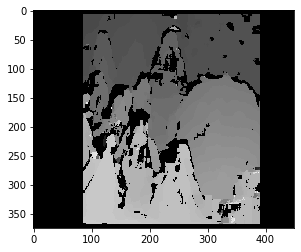

In [6]:
import cv2 as cv
import numpy as np
from tqdm import *
import matplotlib.pyplot as plt


BLOCK_SIZE = 15
SEARCH_ESTIMATION_INI = -30
LIMIT = 100
CRITERE = 0.3

left_image_path="im2.png"
right_image_path="im6.png"
left_im = cv.imread(left_image_path, 0)
right_im = cv.imread(right_image_path, 0)
# Convert image to array
left_im_array = np.asarray(left_im)
right_im_array = np.asarray(right_im)
print(left_im_array.shape)
print(right_im_array.shape)
left_array = left_im_array.astype(int)
right_array = right_im_array.astype(int)
if left_array.shape != right_array.shape:
    raise "Left-Right image shape mismatch!"
    
#get_disparity_map
h, w = left_array.shape
disparity_map = np.zeros((h, w)).astype(np.float32)

#Can by opened by Meshlab
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

def compare_blocks(y, x, block_left, right_array, block_size=BLOCK_SIZE):
    # Get search range for the right image
    x_min = max(int(block_size/2), int(x + (SEARCH_ESTIMATION-30)))
    x_max = min(right_array.shape[1]-int(block_size/2), int(x + (SEARCH_ESTIMATION+30)))

    first = True
    for xx in range(x_min, x_max+1, 3):       
        block_right = right_array[y-int(block_size/2): y+int(block_size/2),
                                  xx-int(block_size/2): xx+int(block_size/2)]
        
        m_l = np.mean(block_left)
        m_r = np.mean(block_right)          
        # zero centred normalized cross-correlation coefficient
        sad = 1 - np.sum(np.multiply(block_left-m_l, block_right-m_r))/np.sqrt(np.sum(np.multiply(block_left-m_l,block_left-m_l))*np.sum(np.multiply(block_right-m_r,block_right-m_r)))
        
        if first:
            min_sad = sad
            min_index = (y, xx)
            first = False
        else:
            if sad < min_sad:
                min_sad = sad
                min_index = (y, xx)
    
    for xx in range(min_index[1]-5, min_index[1]+6):
        block_right = right_array[y-int(block_size/2): y+int(block_size/2),
                                  xx-int(block_size/2): xx+int(block_size/2)]
        
        m_l = np.mean(block_left)
        m_r = np.mean(block_right)          
        # zero centred normalized cross-correlation coefficient
        sad = 1 - np.sum(np.multiply(block_left-m_l, block_right-m_r))/np.sqrt(np.sum(np.multiply(block_left-m_l,block_left-m_l))*np.sum(np.multiply(block_right-m_r,block_right-m_r)))
        
        if sad < min_sad:
            min_sad = sad
            min_index = (y, xx)
            
    if min_sad > CRITERE:
        min_index = (y, x)
               
    return min_index

###################""# Go over each pixel position
SEARCH_ESTIMATION = SEARCH_ESTIMATION_INI
for y in tqdm(range(int(BLOCK_SIZE/2), h-int(BLOCK_SIZE/2))):
    for x in range(max(int(BLOCK_SIZE/2+LIMIT/2),int(BLOCK_SIZE/2+LIMIT/2-SEARCH_ESTIMATION_INI)), min(int(w-LIMIT/2-BLOCK_SIZE/2),int(w-LIMIT/2-BLOCK_SIZE/2)-SEARCH_ESTIMATION_INI)):
        block_left = left_array[y-int(BLOCK_SIZE/2):y + int(BLOCK_SIZE/2),
                                x-int(BLOCK_SIZE/2):x + int(BLOCK_SIZE/2)]
        min_index = compare_blocks(y, x, block_left, right_array, block_size=BLOCK_SIZE)
        disparity_map[y, x] = (min_index[1] - x)

print('generating 3d point cloud...',)
h, w = left_array.shape[:2]
f = 0.8*w                          # guess for focal length
Q = np.float32([[1, 0, 0, -0.5*w],
                [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis, 
                [0, 0, 0,     -f], # so that y-axis looks up
                [0, 0, -1,      0]])
points = cv.reprojectImageTo3D(abs(disparity_map), Q)
colors = cv.cvtColor(cv.imread(left_image_path, cv.IMREAD_COLOR), cv.COLOR_BGR2RGB)

mask = abs(disparity_map) > 0 #< LIMIT #disparity_map.min()
out_points = points[mask.astype(np.bool)]
out_colors = colors[mask.astype(np.bool)]
out_fn = 'PointsCloud_3.ply'
write_ply(out_fn, out_points, out_colors)
print('%s saved' % out_fn)
        
# Normalize the values to a range from 0..255 for a grayscale image
Disparity = cv.normalize(abs(disparity_map), abs(disparity_map), alpha=255, beta=0, norm_type=cv.NORM_MINMAX)
Disparity = np.uint8(Disparity)

plt.imshow(Disparity, cmap='gray', interpolation='nearest')
plt.savefig('DepthMap_3.png')
plt.show()

generating 3d point cloud...
Points_Cloud_3.ply saved


True

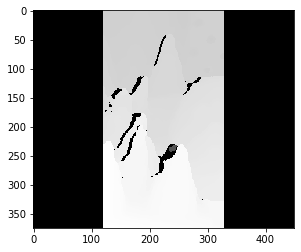

In [6]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

imgL= 'im2.png'
imgR= 'im6.png'

img1_undistorted = cv.imread(imgL, 0)
img2_undistorted = cv.imread(imgR, 0)

#Can by opened by Meshlab
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

#https://docs.opencv.org/4.5.2/d2/d85/classcv_1_1StereoSGBM.html

# Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
block_size = 10
min_disp = -120
max_disp = 120
# Maximum disparity minus minimum disparity. The value is always greater than zero.
# In the current implementation, this parameter must be divisible by 16.
num_disp = max_disp - min_disp
# Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
# Normally, a value within the 5-15 range is good enough
uniquenessRatio = 5
# Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
# Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
speckleWindowSize = 50
# Maximum disparity variation within each connected component.
# If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
# Normally, 1 or 2 is good enough.
speckleRange = 1
disp12MaxDiff = 2

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)
disp = stereo.compute(img1_undistorted, img2_undistorted)

# Normalize the values to a range from 0..255 for a grayscale image
disparity_SGBM = cv.normalize(disp, disp, alpha=255,
                              beta=0, norm_type=cv.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)

print('generating 3d point cloud...',)
h, w = img1_undistorted.shape[:2]
f = 0.8*w                          # guess for focal length
Q = np.float32([[1, 0, 0, -0.5*w],
                [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis, 
                [0, 0, 0,     -f], # so that y-axis looks up
                [0, 0, 1,      0]])
points = cv.reprojectImageTo3D(disp, Q)
colors = cv.cvtColor(cv.imread(imgL), cv.COLOR_BGR2RGB)
mask = disp > disp.min()
out_points = points[mask]
out_colors = colors[mask]
out_fn = 'Points_Cloud_3.ply'
write_ply(out_fn, out_points, out_colors)
print('%s saved' % out_fn)
    
plt.imshow(disparity_SGBM, cmap ='gray')
cv.imwrite("disparity_SGBM_norm_3.png", disparity_SGBM)

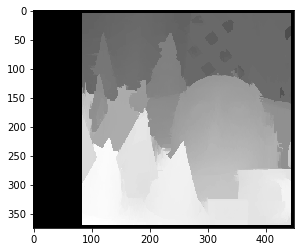

In [14]:
#DisparityWLSFilter
import cv2
import matplotlib.pyplot as plt

imgL= 'im2.png'
imgR= 'im6.png'

left_image = cv2.imread(imgL, 0)
right_image = cv2.imread(imgR, 0)

wsize=11
max_disp = 80
sigma = 1.5
lmbda = 8000.0

left_matcher = cv2.StereoBM_create(max_disp, wsize);
right_matcher = cv2.ximgproc.createRightMatcher(left_matcher);
left_disp = left_matcher.compute(left_image, right_image);
right_disp = right_matcher.compute(right_image,left_image);

# Now create DisparityWLSFilter
wls_filter = cv2.ximgproc.createDisparityWLSFilter(left_matcher);
wls_filter.setLambda(lmbda);
wls_filter.setSigmaColor(sigma);
filtered_disp = wls_filter.filter(left_disp, left_image, disparity_map_right=right_disp);

plt.imshow(filtered_disp, cmap ='gray')

In [ ]:
# StereoSGBM Parameter explanations: https://docs.opencv.org/4.5.0/d2/d85/classcv_1_1StereoSGBM.html
#https://www.andreasjakl.com/how-to-apply-stereo-matching-to-generate-depth-maps-part-3/
#https://docs.opencv.org/master/d3/d14/tutorial_ximgproc_disparity_filtering.html

In [5]:
#♣point cloud viewer: https://heremaps.github.io/pptk/viewer.html
import pptk
import numpy as np
import plyfile

data = plyfile.PlyData.read('Points_Cloud.ply')['vertex']

xyz = np.c_[data['x'], data['y'], data['z']]
rgb = np.c_[data['red'], data['green'], data['blue']]
#n = np.c_[data['nx'], data['ny'], data['nz']]

v = pptk.viewer(xyz)
v.attributes(rgb / 255.)#, 0.5 * (1 + n)
v.set(point_size=0.01)

In [5]:
#http://www.open3d.org/docs/latest/tutorial/Basic/pointcloud.html
import open3d

pcd = open3d.io.read_point_cloud('Points_Cloud.ply')
open3d.visualization.draw_geometries([pcd])